In [1]:
# import the general stuff
import os
from os import getcwd
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np
#from sklearn import metrics
#import math

#import stuff for gradCAM
#import matplotlib.cm as cm
#from IPython.display import Image

#If nm,ultiople GPU, set which GPU to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

#import the tf stuff
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model

from tensorflow.keras.preprocessing.image import ImageDataGenerator

#Check TensorFlow Version
print('TF version: {}' .format(tf.__version__))

TF version: 2.3.2


In [2]:
# #code for GPU mem growth needed for EBG Laptop

# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [3]:
#Check for GPU utilization
if tf.test.gpu_device_name():
    print(' GPU: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU")

 GPU: /device:GPU:0


In [4]:
#data
df = pd.read_csv('../data/SedMLdata.csv')
df.head()

,CropName,D2mm,D5mm,D10mm,D16mm,D25mm,D50mm,D75mm,D84mm,D90mm,D95mm,D98mm,skew,kurtosis
0,F1crop1.jpg,0.202,0.255,0.328,0.417,0.600,1.049,1.475,1.690,1.941,2.243,2.621,-0.310,0.992
1,F1crop2.jpg,0.168,0.194,0.224,0.256,0.305,0.481,0.974,1.420,2.143,2.982,3.980,0.298,0.965
2,F1crop3.jpg,0.128,0.144,0.160,0.176,0.198,0.304,0.540,0.700,0.897,1.172,1.598,0.247,0.857
3,F1crop4.jpg,0.218,0.273,0.346,0.429,0.621,1.283,1.821,2.040,2.241,2.532,2.873,-0.398,0.850
4,F1crop5.jpg,0.134,0.153,0.174,0.194,0.221,0.332,0.780,1.139,1.532,1.851,2.376,0.384,0.810


In [8]:
#build data generators for training and validaton

split = 0.5

df = pd.read_csv('../data/SedMLdata.csv')
columns=["D2mm", "D5mm", "D10mm", "D16mm",
"D25mm","D50mm", "D75mm", "D84mm", "D90mm",
"D95mm", "D98mm"]

# Define dirs and files
train_data_dir = '../data/CropPics'

# Add our data-augmentation parameters to ImageDataGenerator and split data
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   validation_split = split)


#set batch Size
batch_size = 16

#set color
c_ch = 1
c_mode = 'grayscale'
# c_ch = 3
# c_mode = 'rgb'

#set Image size (RGB so imshape is 3)
pix_dim = 1024
imsize = (pix_dim, pix_dim) 
imshape = (pix_dim, pix_dim, c_ch)

# Flow training images in batches 
train_generator = train_datagen.flow_from_dataframe(dataframe = df,
                                                    directory = train_data_dir,
                                                    batch_size = batch_size,
                                                    class_mode = 'raw',
                                                    x_col = 'CropName',
                                                    y_col = columns,
                                                    target_size = imsize,
                                                    color_mode = c_mode,
                                                    subset = 'training')

# Flow validation images in batches 
validation_generator =  train_datagen.flow_from_dataframe(dataframe=df,
                                                          directory = train_data_dir,
                                                          batch_size = batch_size,
                                                          class_mode = 'raw',
                                                          x_col = 'CropName',
                                                          y_col = columns,
                                                          target_size = imsize,
                                                          color_mode = c_mode,
                                                          subset = 'validation')

Found 150 validated image filenames.
Found 150 validated image filenames.


In [9]:
total_train = 150
total_val = 150

Stats : [0.145 0.16  0.173 0.185 0.198 0.231 0.273 0.299 0.328 0.378 0.476]


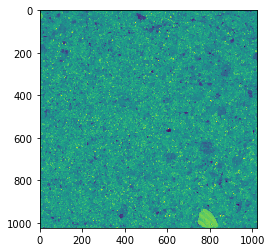

In [10]:
#show augs

how_many = 1
#how_many = batch size

x = validation_generator.next()

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    plt.imshow(image.squeeze())   #squeeze for grayscale images
    print('Stats :', x[1][i])
    plt.show()

In [11]:
#model
baseFilter= 32

model = tf.keras.Sequential([
    layers.InputLayer(input_shape=imshape),
    
    layers.SeparableConv2D(filters = baseFilter, kernel_size=3, padding='same', activation='relu'),
    layers.SeparableConv2D(baseFilter*2, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*3, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*4, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*5, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*6, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.SeparableConv2D(baseFilter*7, 3, padding='same', activation='relu'),
    #layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.GlobalMaxPooling2D(),
    #layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(columns), activation="linear")
])


model._name = "SandCam_CNN"

model.summary()


Model: "SandCam_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
separable_conv2d (SeparableC (None, 1024, 1024, 32)    73        
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 1024, 1024, 64)    2400      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 512, 512, 64)      0         
_________________________________________________________________
separable_conv2d_2 (Separabl (None, 512, 512, 96)      6816      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 256, 256, 96)      0         
_________________________________________________________________
separable_conv2d_3 (Separabl (None, 256, 256, 128)     13280     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 128)     

In [12]:
# #determine the learning rate

# callbacks = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch/10))

# model.compile(loss = 'mean_squared_error',
#              optimizer = tf.keras.optimizers.Adam(lr = 1e-8),
#              metrics = mae_metric)

# history = model.fit(train_generator,
#                     steps_per_epoch = total_train // batch_size,
#                     validation_data = validation_generator,
#                     epochs= 100,
#                     workers = 8,
#                     validation_steps =  total_val // batch_size,
#                     callbacks =[callbacks])

In [13]:
#LOSS CURVE

In [14]:
# define other metrics
metrics = tf.keras.metrics.MeanAbsolutePercentageError(name='mape')

In [15]:
#compile
model.compile(loss='mean_squared_error', 
              optimizer=tf.keras.optimizers.Adam(),
              metrics = metrics
             )

In [16]:
# define a callback

early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', 
                                             patience = 20, 
                                             restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                                 factor = 0.2,
                                                 verbose = 1,
                                                 patience = 5)

In [17]:
#train the model
history = model.fit(train_generator,
                    steps_per_epoch = total_train // batch_size,
                    validation_data = validation_generator,
                    epochs= 200,
                    workers = 8,
                    validation_steps =  total_val // batch_size,
                    callbacks =[early_stop, reduce_lr])

Epoch 1/200
9/9 [==============================] - 19s 2s/step - loss: 0.8570 - mape: 94.2408 - val_loss: 1.1905 - val_mape: 82.4490
Epoch 2/200
9/9 [==============================] - 20s 2s/step - loss: 0.7327 - mape: 71.8470 - val_loss: 0.9220 - val_mape: 52.5188
Epoch 3/200
9/9 [==============================] - 19s 2s/step - loss: 0.5881 - mape: 108.6626 - val_loss: 0.7282 - val_mape: 59.3453
Epoch 4/200
9/9 [==============================] - 19s 2s/step - loss: 0.5585 - mape: 101.8191 - val_loss: 0.6615 - val_mape: 45.5928
Epoch 5/200
9/9 [==============================] - 18s 2s/step - loss: 0.5001 - mape: 92.8639 - val_loss: 0.6212 - val_mape: 45.1952
Epoch 6/200
9/9 [==============================] - 19s 2s/step - loss: 0.4914 - mape: 102.2393 - val_loss: 0.6285 - val_mape: 37.3788
Epoch 7/200
9/9 [==============================] - 17s 2s/step - loss: 0.4357 - mape: 83.2848 - val_loss: 0.6726 - val_mape: 34.1771
Epoch 8/200
9/9 [==============================] - 18s 2s/step - l

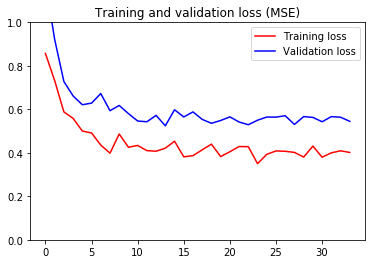

<Figure size 432x288 with 0 Axes>

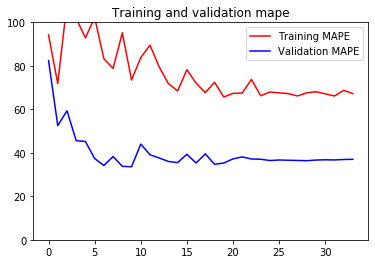

<Figure size 432x288 with 0 Axes>

In [18]:
#look at the metrics from training
%matplotlib inline

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.ylim(0,1)

plt.title('Training and validation loss (MSE)')
plt.legend(loc=0)
plt.figure()
plt.show()

mae = history.history['mape']
val_mae = history.history['val_mape']

plt.plot(epochs, mae, 'r', label='Training MAPE')
plt.plot(epochs, val_mae, 'b', label='Validation MAPE')
plt.ylim(0,100)

plt.title('Training and validation mape')
plt.legend(loc=0)
plt.figure()
plt.show()


Stats : [0.145 0.16  0.173 0.185 0.198 0.231 0.273 0.299 0.328 0.378 0.476]
Predicted Stats: [[0.12843767 0.1744507  0.18562652 0.253853   0.26884213 0.34476757
  0.49263924 0.6404706  0.7766587  0.94524854 1.2027142 ]]


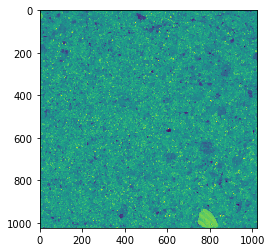

Stats : [0.212 0.254 0.315 0.398 0.621 1.155 1.684 2.02  2.466 2.909 4.012]
Predicted Stats: [[0.12843767 0.1744507  0.18562652 0.25385293 0.26884213 0.34476757
  0.49263918 0.6404705  0.7766586  0.9452483  1.2027141 ]]


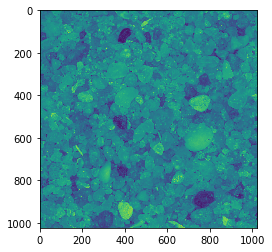

In [19]:
#Eventually, we will use model.evaluate() with the Duck Field samples... 
#until they are processed, we just use the validation egnerator as a sanity check

SC = validation_generator.next()

how_many = 2
#how_many = batch size

for i in range(0,how_many):
    image = x[0][i]   # batch[0] images, batch[1] labels... 
    #make a prediction
    img = np.expand_dims(image,axis=0)
    predStats = model.predict(img)
    
    plt.imshow(image.squeeze())   #squeeze for grayscale images  
    print('Stats :',x[1][i])
    print('Predicted Stats:', predStats)
    plt.show()

In [ ]:
#save the model
filepath = './models/SNmodel'
model.save(filepath)


In [ ]:
# #model size
# model.save("./models/SNmodel.h5")
# model_file ='./models/SNmodel.h5'
# b = os.path.getsize(model_file)
# print ("Size(mb): %d" % (b/1000000))

In [ ]:
#prune

In [ ]:
#quantize

In [ ]:
#test Quantize